In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
from torchvision import datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import InterpolationMode
%matplotlib inline

In [3]:
filepath = "/content/drive/MyDrive/Colab Notebooks/2023/Mask Inpainting GAN"

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [5]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

mkdir: cannot create directory ‘data_faces’: File exists


In [6]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [7]:
import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [8]:
# !pip install Pillow==4.0.0
# !pip install PIL
# !pip install image
# import PIL.Image as Image

In [38]:
crop_size = 150
re_size = 64
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

In [39]:
re_size = 64
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Lambda(crop),
     torchvision.transforms.ToPILImage(),
     torchvision.transforms.Resize(size=(re_size, re_size), interpolation=InterpolationMode.BICUBIC),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

In [68]:
batch_size = 64
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)
data_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True, drop_last=True)

In [55]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

In [56]:
# pip install pillow --upgrade

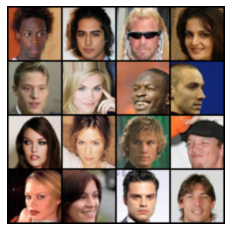

In [57]:
batch, _ = next(iter(data_loader))
show(batch[0:16], renorm = True, nrow=4)

In [58]:
nz = 100
ngf = 64
ndf = 64

In [59]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.dconv1 = nn.ConvTranspose2d(nz,ngf*8,4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        self.dconv2 = nn.ConvTranspose2d(ngf*8,ngf*4, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*4)
        self.dconv3 = nn.ConvTranspose2d(ngf*4,ngf*2,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)
        self.dconv4 = nn.ConvTranspose2d(ngf*2,ngf,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.dconv5 = nn.ConvTranspose2d(ngf,3,4,stride=2,padding=1,bias=False)

        for layer in self.modules():
            if isinstance(layer, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(layer.weight.data)

    def forward(self,x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))
        x = F.relu(self.bn3(self.dconv3(x)))
        x = F.relu(self.bn4(self.dconv4(x)))
        x = torch.tanh(self.dconv5(x))
        return x

G = Generator().to(device)

In [60]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,ndf,4,stride=2,padding=1,bias=False)
        self.conv2 = nn.Conv2d(ndf,ndf*2,4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2,ndf*4,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4,ndf*8,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*8)
        self.conv5 = nn.Conv2d(ndf*8,1,4,stride=1,padding=0,bias=False)

        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight.data)
      
    def forward(self,x):
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        x = torch.sigmoid(self.conv5(x))
        return x.view(-1,1)

D = Discriminator().to(device)

In [61]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

In [62]:
criterion = nn.BCELoss()

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

In [63]:
def G_train():
    G.zero_grad()

    z = torch.randn(batch_size, nz, 1, 1)
    label = torch.ones(batch_size, 1)

    z = z.to(device)
    label = label.to(device)

    G_output = G(z)
    D_output = D(G_output)
    
    loss = criterion(D_output, label)
    loss.backward()
    G_optimizer.step()

    return loss.data.item()

In [64]:
def D_train(images):
    D.zero_grad()

    labels_real = torch.ones(batch_size, 1)
    labels_real = labels_real.to(device)
    
    D_output = D(images)
    loss_real = criterion(D_output, labels_real)

    z = torch.randn(batch_size, nz, 1, 1)
    labels_fake = torch.zeros(batch_size, 1)

    z = z.to(device)
    labels_fake = labels_fake.to(device)

    G_output = G(z)
    D_output = D(G_output)
    loss_fake = criterion(D_output, labels_fake)
    
    loss_total = (loss_real + loss_fake) / 2
    loss_total.backward()
    D_optimizer.step()
    

    return loss_total.data.item()

In [65]:
import os.path

if os.path.exists(f"{filepath}/model/G_model_state_dict.pt"):
    G.load_state_dict(torch.load(f"{filepath}/model/G_model_state_dict.pt"))
    G_optimizer.load_state_dict(torch.load(f"{filepath}/model/G_optim_state_dict.pt"))
    D.load_state_dict(torch.load(f"{filepath}/model/D_model_state_dict.pt"))
    D_optimizer.load_state_dict(torch.load(f"{filepath}/model/D_optim_state_dict.pt"))
    print('Load Complete')
else:
    print('Load Fail')

Load Fail


In [66]:
best_g_loss = float('inf')

In [69]:
n_epoch = 200
for epoch in range(n_epoch):
    D_loss_list, G_loss_list = [], []
    for batch_idx, (images, _) in enumerate(data_loader):
        images = images.to(device)
        D_loss = D_train(images)
        D_loss_list.append(D_loss)

        G_loss = G_train()
        G_loss_list.append(G_loss)

        if batch_idx % 100 == 0:
          print(f"Iter {batch_idx}/3100 Complete")
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
        (epoch), n_epoch, torch.mean(torch.FloatTensor(D_loss_list)), torch.mean(torch.FloatTensor(G_loss_list))))
    loss_g = torch.mean(torch.FloatTensor(G_loss_list))
    if loss_g < best_g_loss:
        best_loss = loss_g
        best_G_model_state = G.state_dict()
        best_G_optim_state = G_optimizer.state_dict()
        torch.save(best_G_model_state, f"{filepath}/model/G_model_state_dict.pt")
        torch.save(best_G_optim_state, f"{filepath}/model/G_optim_state_dict.pt")

        torch.save(D.state_dict(), f"{filepath}/model/D_model_state_dict.pt")
        torch.save(D_optimizer.state_dict(), f"{filepath}/model/D_optim_state_dict.pt")


Iter 0/3100 Complete
Iter 100/3100 Complete
Iter 200/3100 Complete
Iter 300/3100 Complete
Iter 400/3100 Complete
Iter 500/3100 Complete
Iter 600/3100 Complete
Iter 700/3100 Complete
Iter 800/3100 Complete
Iter 900/3100 Complete
Iter 1000/3100 Complete
Iter 1100/3100 Complete
Iter 1200/3100 Complete
Iter 1300/3100 Complete
Iter 1400/3100 Complete
Iter 1500/3100 Complete
Iter 1600/3100 Complete
Iter 1700/3100 Complete
Iter 1800/3100 Complete
Iter 1900/3100 Complete
Iter 2000/3100 Complete
Iter 2100/3100 Complete
Iter 2200/3100 Complete
Iter 2300/3100 Complete
Iter 2400/3100 Complete
Iter 2500/3100 Complete
Iter 2600/3100 Complete
Iter 2700/3100 Complete
Iter 2800/3100 Complete
Iter 2900/3100 Complete
Iter 3000/3100 Complete
Iter 3100/3100 Complete
[0/200]: loss_d: 34.785, loss_g: 11.489
Iter 0/3100 Complete
Iter 100/3100 Complete
Iter 200/3100 Complete
Iter 300/3100 Complete
Iter 400/3100 Complete
Iter 500/3100 Complete
Iter 600/3100 Complete
Iter 700/3100 Complete
Iter 800/3100 Complete

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    z = torch.randn(batch_size, nz)
    z.to(device)
    sample = G(z)
    save_image(sample.view(sample.size(0), 1, 64, 64), f"{filepath}/samples/sample.png")